In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import torchvision.utils as vutils
import os


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:02<00:00, 69825051.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


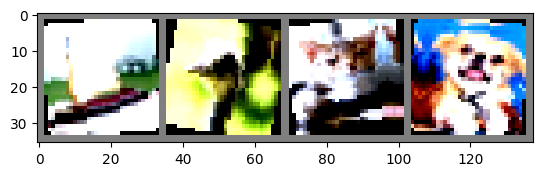

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 32, 32]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 32/3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 32, 32]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 16, 16]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 16, 16]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )  # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 8, 8]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 6, 6]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, 4, 4]),  # Using Layer Normalization
            nn.Dropout(dropout_value)
        )  # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )  # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
         LayerNorm-3           [-1, 32, 32, 32]          65,536
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
         LayerNorm-7           [-1, 32, 32, 32]          65,536
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
        LayerNorm-13           [-1, 32, 16, 16]          16,384
          Dropout-14           [-1

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    incorrect_examples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Collect incorrect examples
            incorrect_mask = pred.eq(target.view_as(pred)).squeeze() == 0
            incorrect_examples.extend(data[incorrect_mask])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

    # Plot incorrect examples
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(len(incorrect_examples), 10)):
        plt.subplot(5, 5, i + 1)
        plt.tight_layout()
        # Transpose the image tensor to match the format expected by matplotlib
        img = incorrect_examples[i].cpu().numpy().transpose(1, 2, 0)
        # Normalize the image data to the range [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Predicted: {}, Actual: {}".format(pred[i].cpu().numpy(), target[i].cpu().numpy()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

EPOCH: 0


Loss=1.6910054683685303 Batch_id=97 Accuracy=29.73: 100%|██████████| 98/98 [00:41<00:00,  2.37it/s]



Test set: Average loss: 1.6381, Accuracy: 4097/10000 (40.97%)



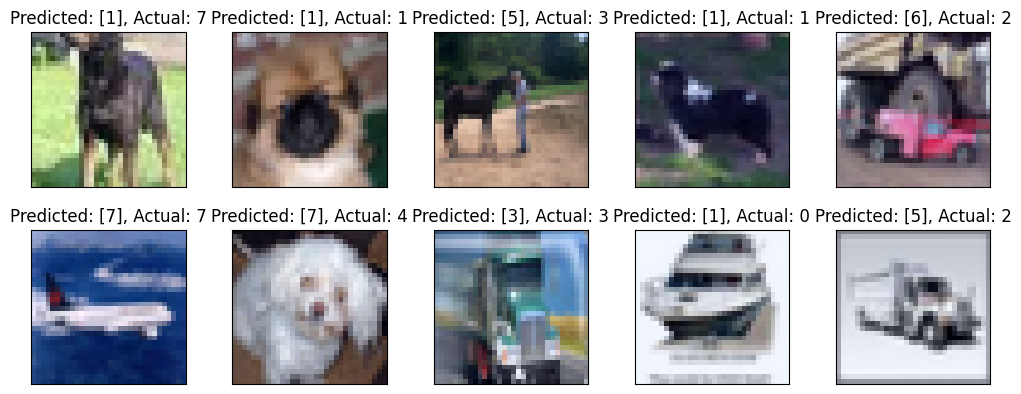

EPOCH: 1


Loss=1.4929072856903076 Batch_id=97 Accuracy=41.40: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]



Test set: Average loss: 1.4534, Accuracy: 4756/10000 (47.56%)



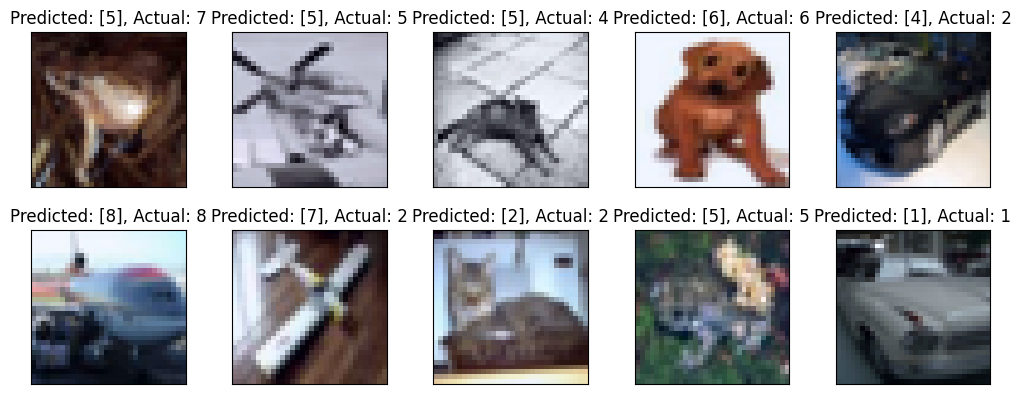

EPOCH: 2


Loss=1.4308637380599976 Batch_id=97 Accuracy=46.28: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 1.4049, Accuracy: 4905/10000 (49.05%)



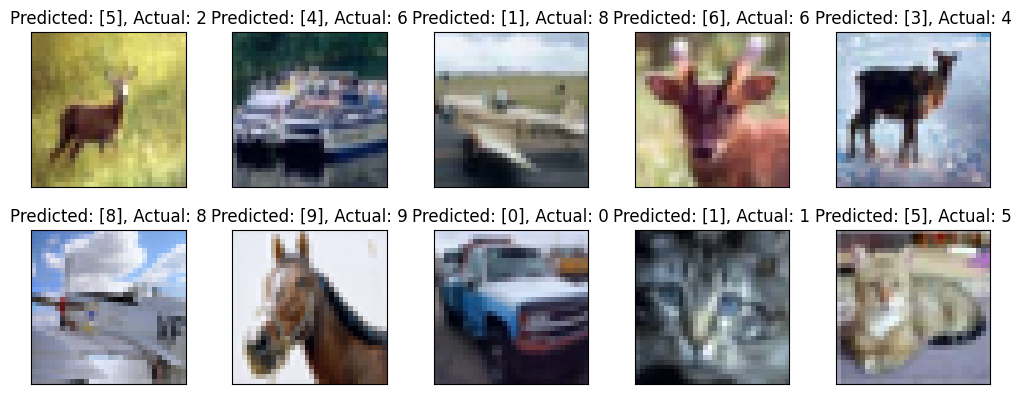

EPOCH: 3


Loss=1.3562746047973633 Batch_id=97 Accuracy=50.30: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 1.2781, Accuracy: 5429/10000 (54.29%)



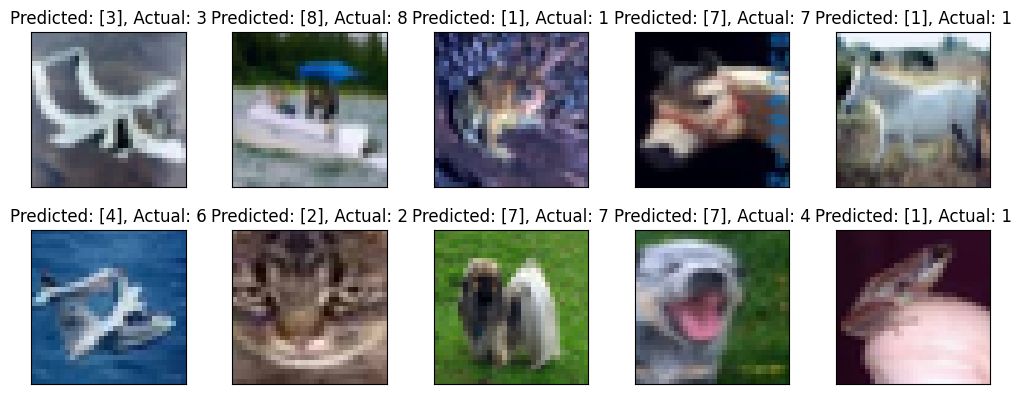

EPOCH: 4


Loss=1.3944408893585205 Batch_id=97 Accuracy=53.52: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 1.2539, Accuracy: 5450/10000 (54.50%)



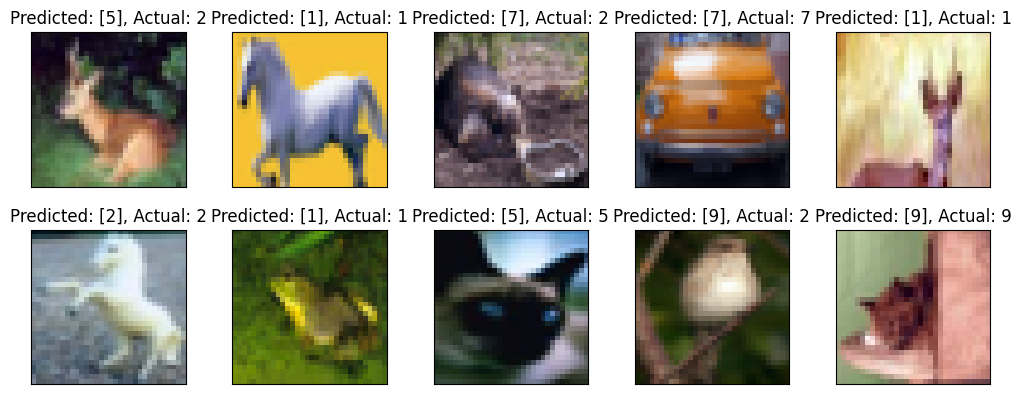

EPOCH: 5


Loss=1.253159999847412 Batch_id=97 Accuracy=55.03: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 1.1371, Accuracy: 5892/10000 (58.92%)



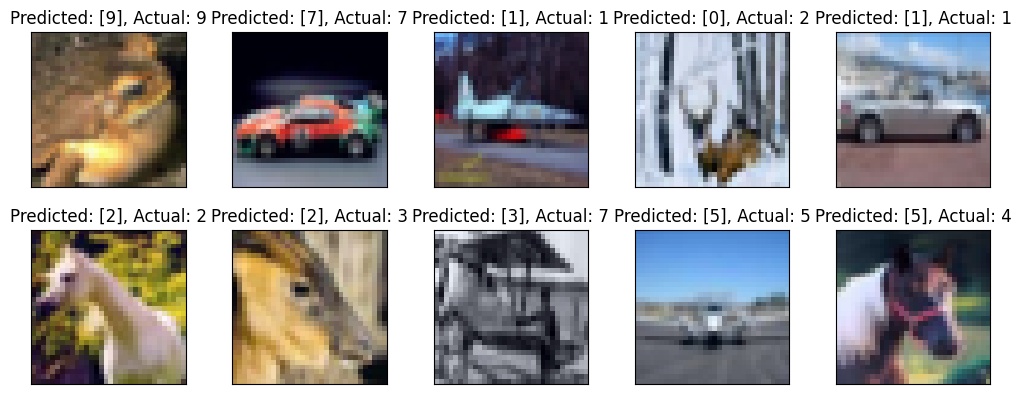

EPOCH: 6


Loss=1.1396528482437134 Batch_id=97 Accuracy=56.89: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 1.0903, Accuracy: 6156/10000 (61.56%)



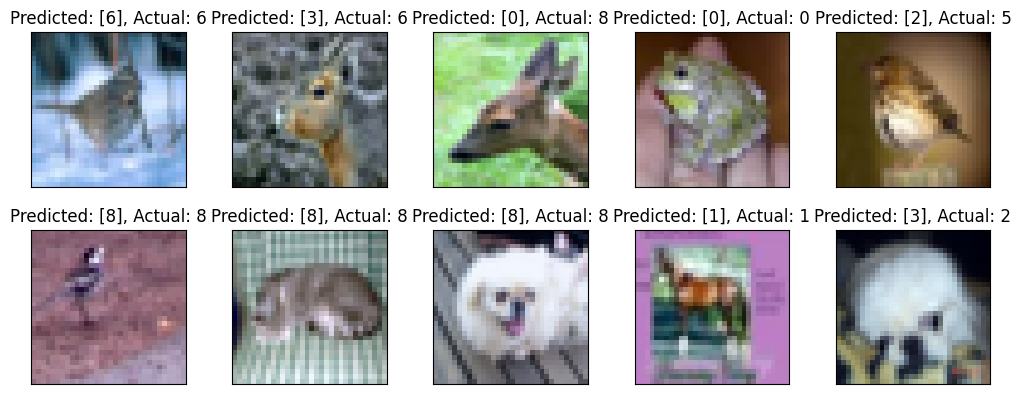

EPOCH: 7


Loss=1.0590546131134033 Batch_id=97 Accuracy=58.88: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 1.0630, Accuracy: 6166/10000 (61.66%)



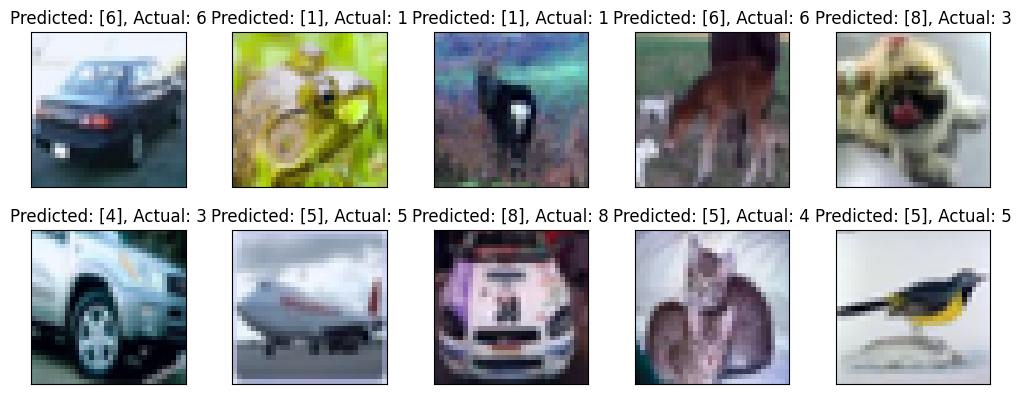

EPOCH: 8


Loss=0.9884055256843567 Batch_id=97 Accuracy=59.84: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]



Test set: Average loss: 1.0089, Accuracy: 6367/10000 (63.67%)



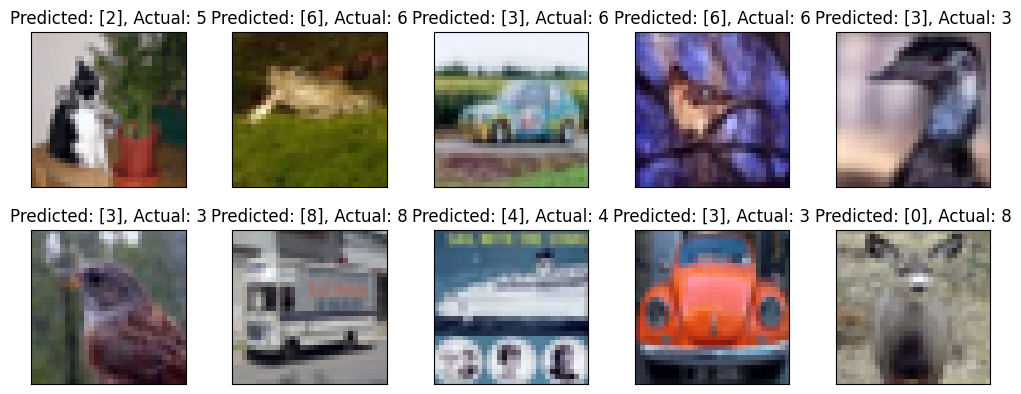

EPOCH: 9


Loss=1.2379075288772583 Batch_id=97 Accuracy=60.88: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]



Test set: Average loss: 0.9715, Accuracy: 6569/10000 (65.69%)



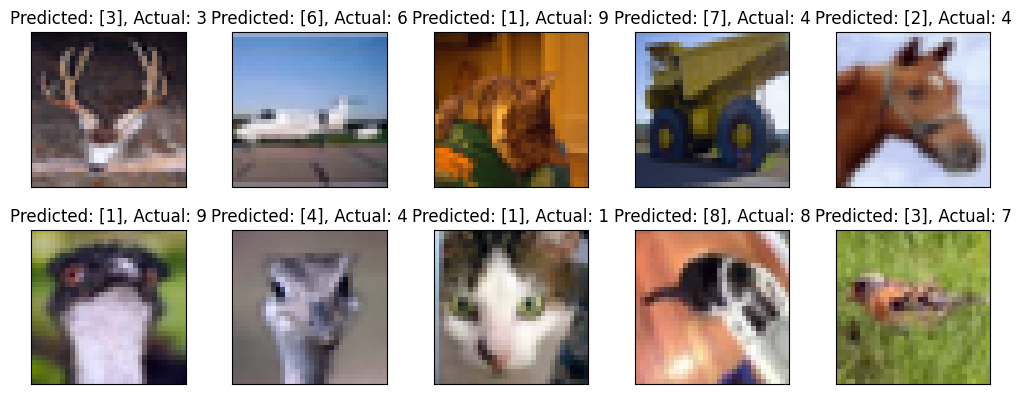

EPOCH: 10


Loss=1.0892655849456787 Batch_id=97 Accuracy=61.73: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.9488, Accuracy: 6646/10000 (66.46%)



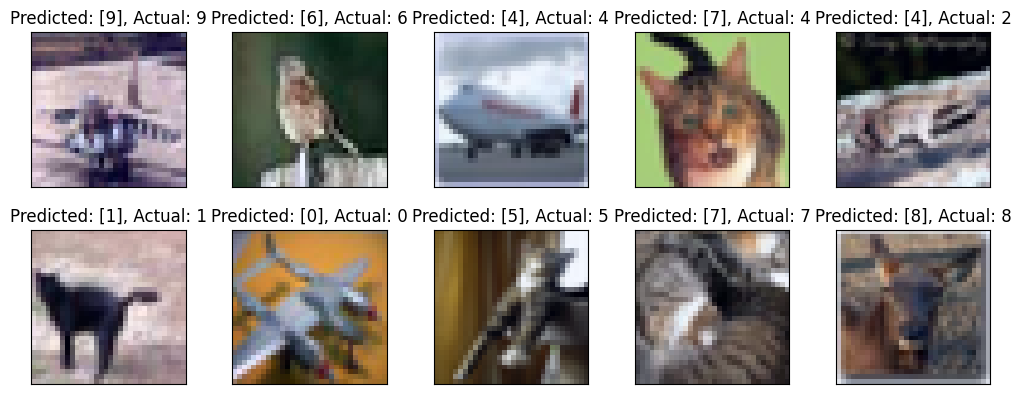

EPOCH: 11


Loss=1.0586607456207275 Batch_id=97 Accuracy=62.87: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.9225, Accuracy: 6725/10000 (67.25%)



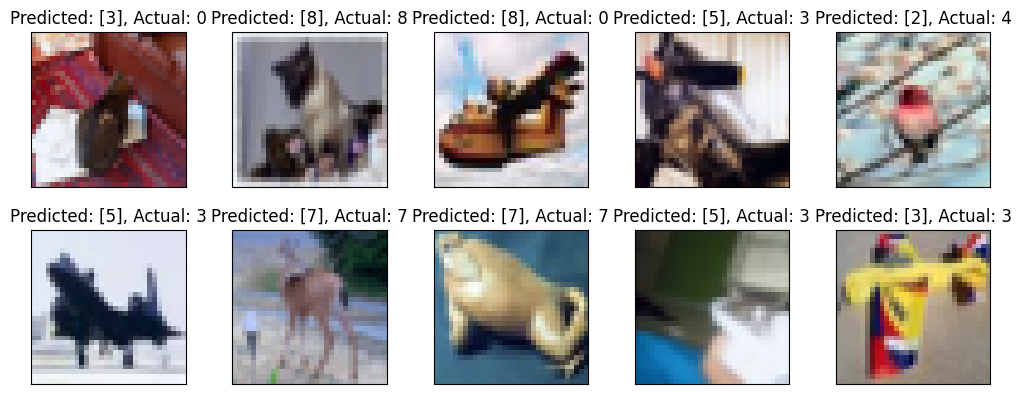

EPOCH: 12


Loss=0.9515329003334045 Batch_id=97 Accuracy=63.52: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.9153, Accuracy: 6692/10000 (66.92%)



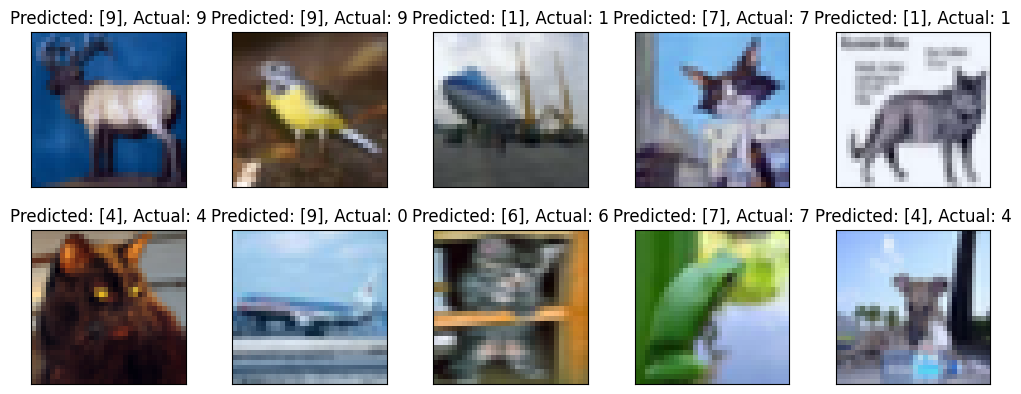

EPOCH: 13


Loss=1.0018792152404785 Batch_id=97 Accuracy=64.25: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.9003, Accuracy: 6833/10000 (68.33%)



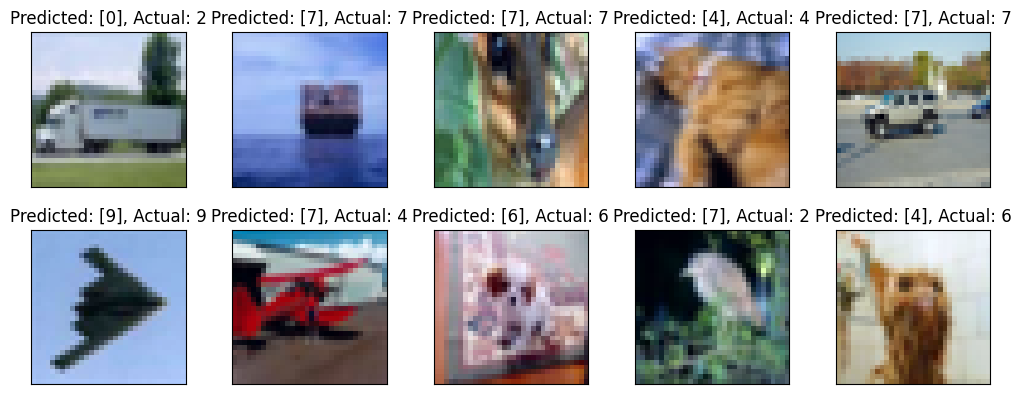

EPOCH: 14


Loss=0.9368180632591248 Batch_id=97 Accuracy=64.88: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.8587, Accuracy: 6982/10000 (69.82%)



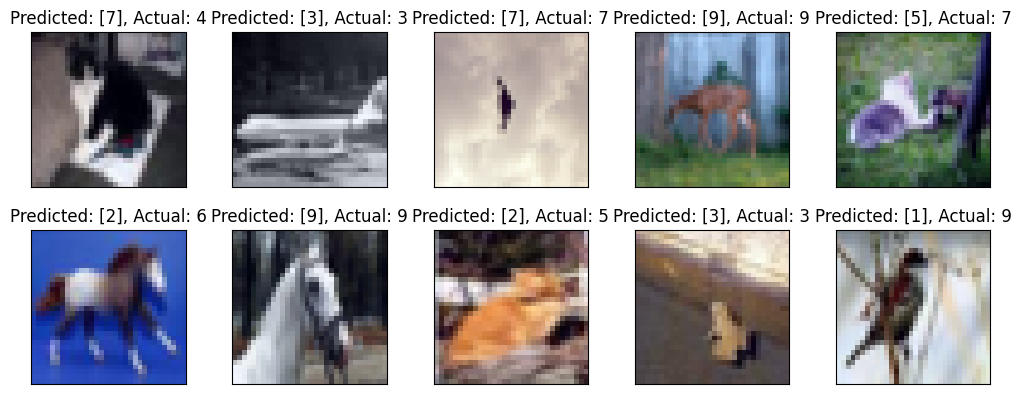

EPOCH: 15


Loss=0.9223719239234924 Batch_id=97 Accuracy=65.66: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.8992, Accuracy: 6833/10000 (68.33%)



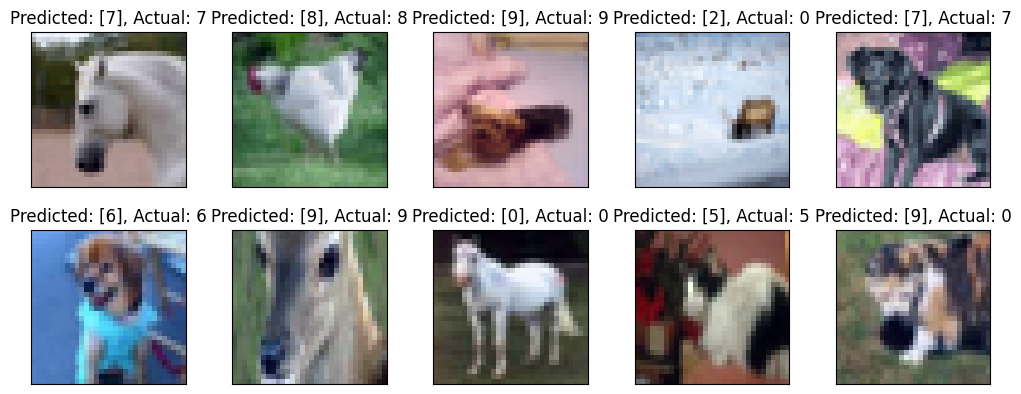

EPOCH: 16


Loss=0.9806388020515442 Batch_id=97 Accuracy=65.57: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.8416, Accuracy: 7025/10000 (70.25%)



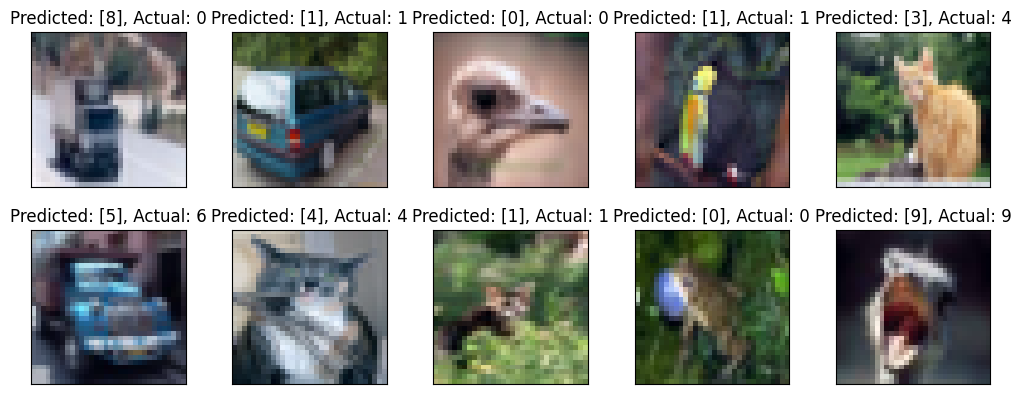

EPOCH: 17


Loss=1.0022556781768799 Batch_id=97 Accuracy=66.60: 100%|██████████| 98/98 [00:33<00:00,  2.95it/s]



Test set: Average loss: 0.7968, Accuracy: 7208/10000 (72.08%)



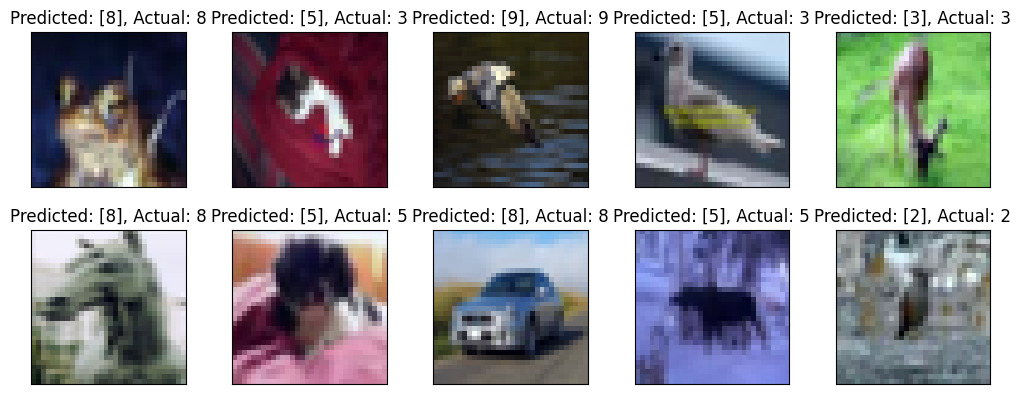

EPOCH: 18


Loss=0.9722855687141418 Batch_id=97 Accuracy=67.23: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 0.8178, Accuracy: 7147/10000 (71.47%)



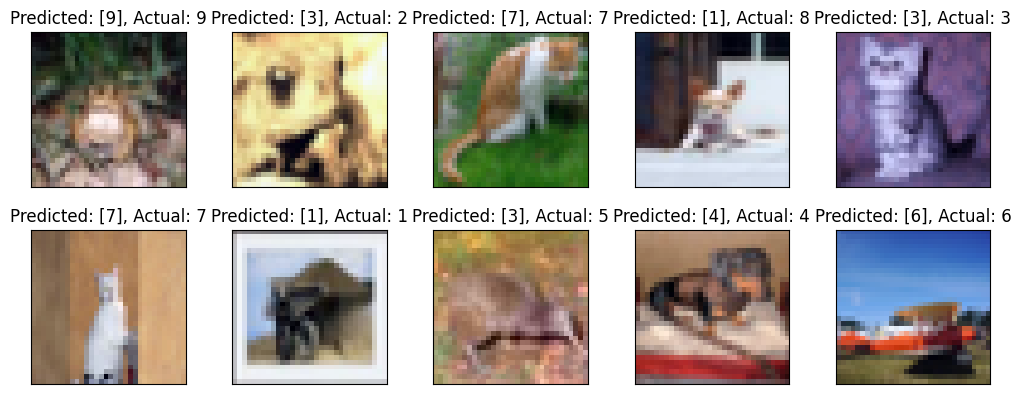

EPOCH: 19


Loss=0.9048033952713013 Batch_id=97 Accuracy=67.69: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.7867, Accuracy: 7254/10000 (72.54%)



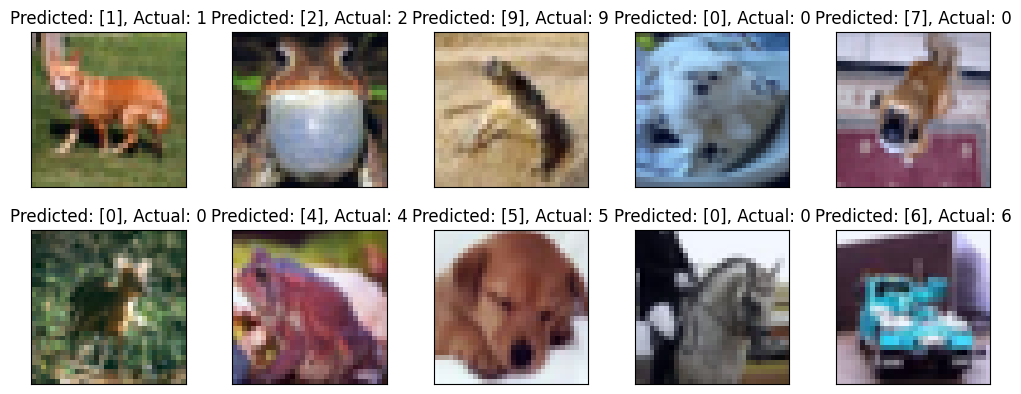

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)